In [1]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
import seaborn as sns

In [2]:
# Code for cool SQL query and filling empty values

In [2]:
data = pd.read_csv('Exam_Score_Prediction.csv')
data.head()


,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
1,2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
2,3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
3,4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
4,5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7


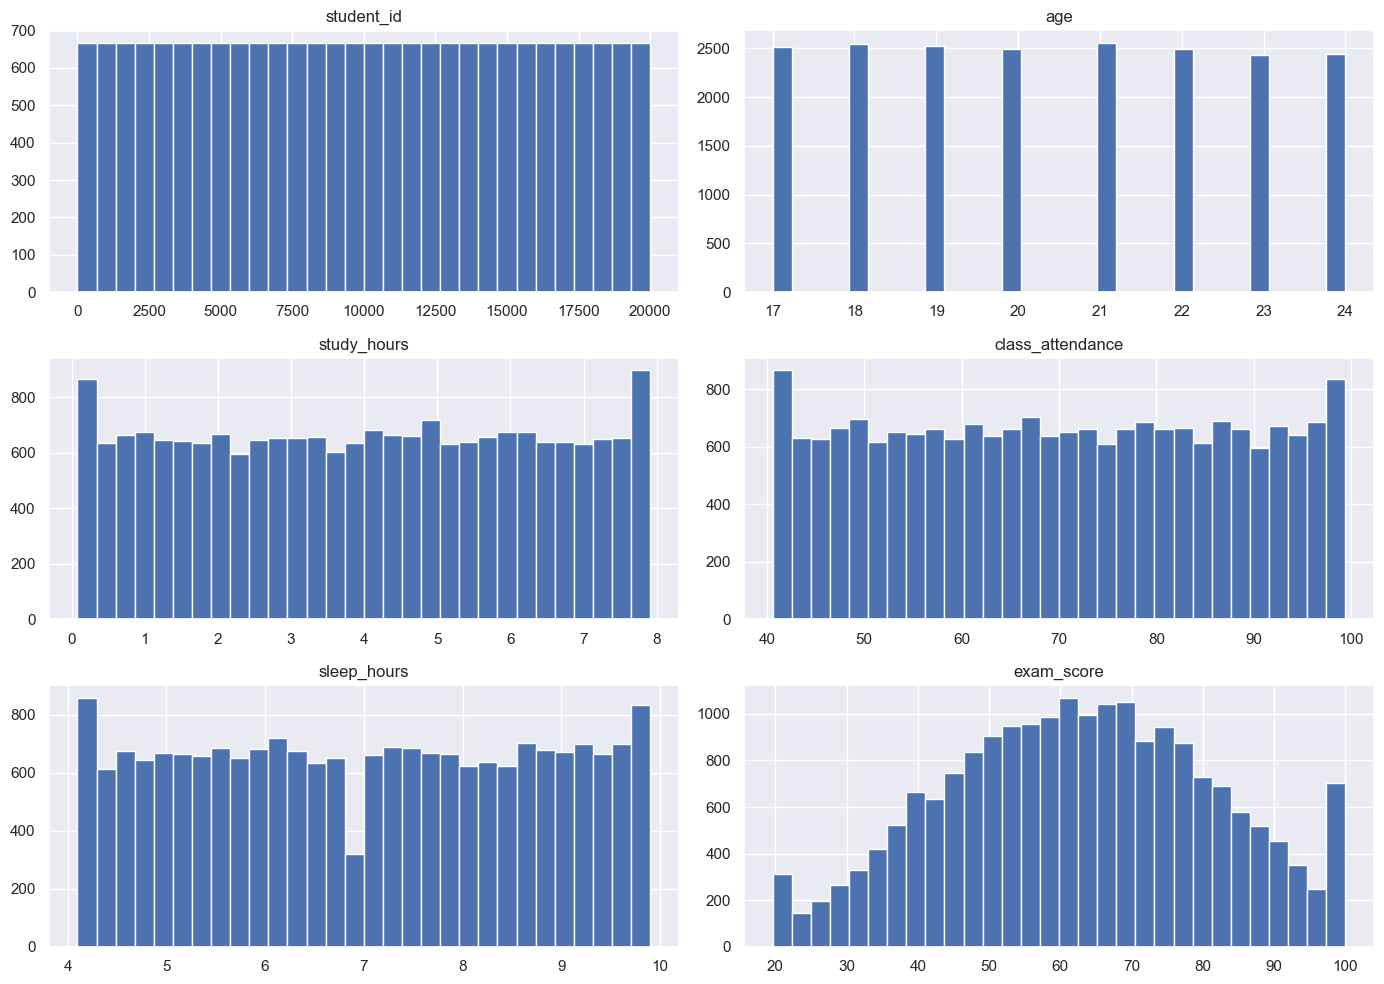

In [3]:
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
data.hist(bins=30, figsize=(14, 10))
plt.tight_layout()

In [4]:
# Parametrs that can be changed
seed = 52
metric = 'MAE' #select maximize or minimize in hyperparams search with optuna 
n_folds = 5

In [30]:
from sklearn.model_selection import train_test_split
from catboost import Pool


y = data.exam_score
X = data.drop('exam_score',axis = 1)


num_cols = X.select_dtypes(include=[np.number])
num_cat_cols = [col for col in num_cols if X[col].nunique() <= 10]
cat_cols = (
    X.select_dtypes(include=['object', 'category']).columns.tolist() +
    num_cat_cols
)
print(cat_cols)


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2,random_state= seed)
X_train_valid , y_train_valid = X_train.copy(), y_train.copy()
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state= seed)

train_pool = Pool(X_train,y_train,cat_features=cat_cols)
eval_pool = Pool(X_valid,y_valid,cat_features=cat_cols)

train_valid_pool = Pool(X_train_valid , y_train_valid,cat_features=cat_cols)
test_pool = Pool(X_test,y_test,cat_features=cat_cols)

['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty', 'age']


In [8]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
dr = DummyRegressor() 
dr.fit(X_train, y_train)
y_dummy_pred = dr.predict(X_test)
print(f'{metric}', mean_absolute_error(y_test,y_dummy_pred))

MAE 15.81123240640625


In [ ]:
from sklearn.model_selection import KFold

def k_fold_training(X,y,cat_features,params,n_splits,seed):
    ''' Function for training model on k folds.
        X - full training dataset (pd.DataFrame)
        y - target  (pd.Series)
        cat_features - list of categorical features from dataset
        params - dict of parameters passed to the model
        n_splits - number of folds
        seed - random_state
        '''

    kf = KFold(n_splits=n_folds)

    scores = []
    models = []
    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_cols)
        eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_cols)

        cbr = CatBoostRegressor(**params)
        models.append(cbr)

        cbr.fit(
            train_dataset,
            eval_set=eval_dataset,
            verbose=False,
            use_best_model=True,
            plot=False)

        scores.append(np.mean([v for k, v in cbr.best_score_["validation"].items() if f"{metric}" in k], dtype="float"))

    print(f'Average score and std for {n_splits} folds on validation dataset: {np.mean(scores):.4f} +- {np.std(scores):.4f}')

    importance_df = pd.DataFrame([model.feature_importances_ for model in models], columns=X_train.columns)


    mean_imp = importance_df.mean()
    std_imp = importance_df.std()


    sorted_idx = mean_imp.sort_values(ascending=False).index
    mean_vals = mean_imp[sorted_idx].values
    std_vals = std_imp[sorted_idx].values
    feature_names = sorted_idx


    y_pos = np.arange(len(feature_names))

    plt.figure(figsize=(10, 8))
    plt.barh(y_pos, mean_vals, xerr=std_vals, align='center', alpha=0.8, capsize=5)

    # Подписи
    for i, (mean_val, std_val) in enumerate(zip(mean_vals, std_vals)):
        plt.text(
            mean_val + max(mean_vals) * 0.05,
            i,
            f'{mean_val:.4f} ± {std_val:.4f}',
            va='center',
            ha='left',
            fontsize=10
        )

    plt.yticks(y_pos, feature_names)
    plt.xlabel('Feature Importance (Mean ± Std)')
    plt.title(f'Feature Importances across {n_splits} CV Folds')
    plt.gca().invert_yaxis()  # самая важная сверху
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    return models 



In [19]:
from catboost.utils import eval_metric

Average score and std for 5 folds on validation dataset: 7.8884 +- 0.0528


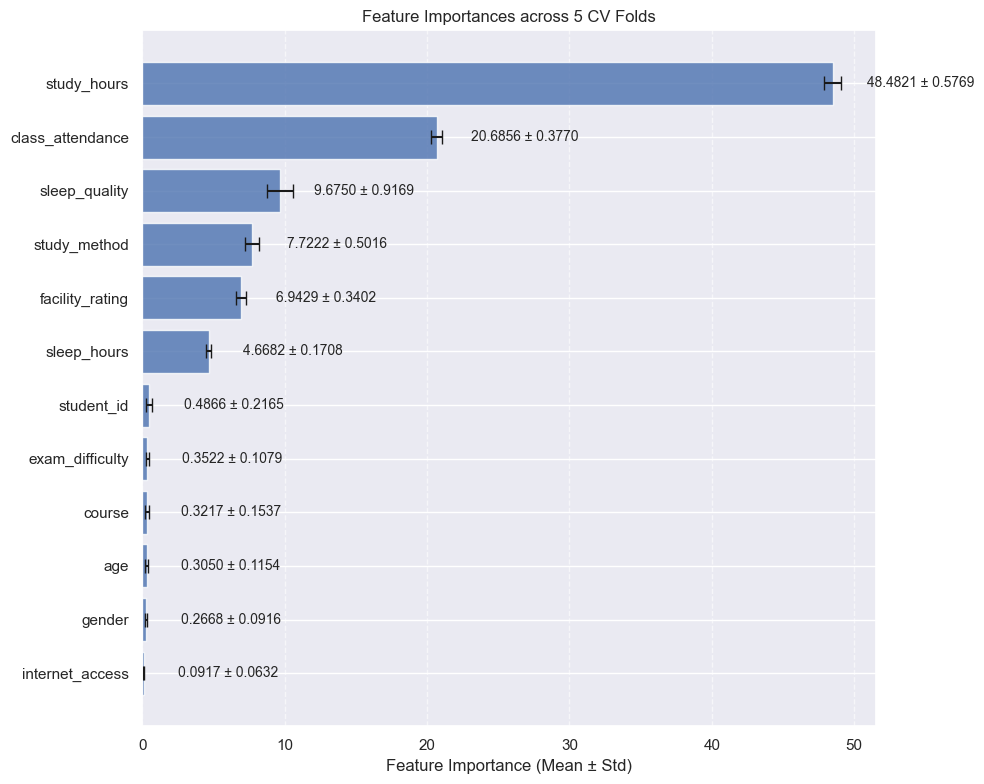

In [33]:
params = {
    'eval_metric' : metric,
    'cat_features': cat_cols,
    'use_best_model': True,
    'early_stopping_rounds': 200,
    'random_seed': seed,
    'ignored_features': None,
    'verbose': False,
    
    }
models_1 = k_fold_training(X_train_valid,y_train_valid,cat_cols,params,n_folds,seed)

Average score and std for 5 folds on validation dataset: 7.8910 +- 0.0434


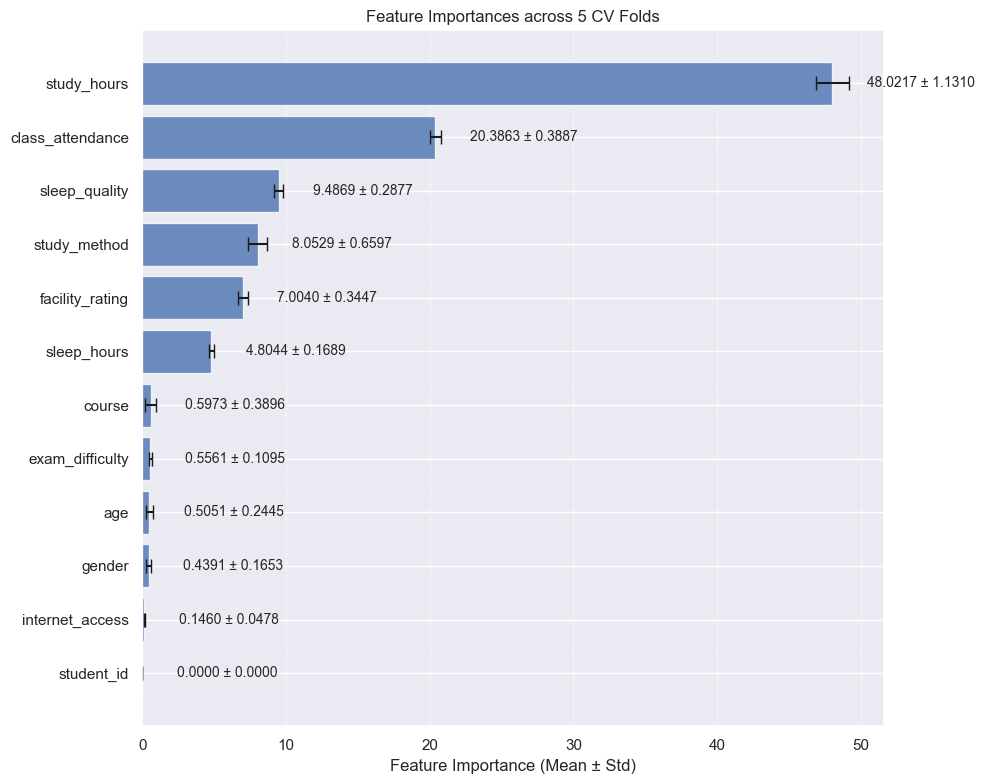

In [26]:
params['ignored_features'] = ['student_id']

models_2 = k_fold_training(X_train_valid,y_train_valid,cat_cols,params,n_folds,seed)

In [27]:
def sleep_change(quality):
    if quality == 'poor':
        return 0.6
    elif quality == 'average':
        return 0.8
    elif quality == 'good':
        return 1

train_valid_copy = X_train_valid.copy()    
train_valid_copy['sleep_score'] = train_valid_copy.sleep_hours * train_valid_copy.sleep_quality.apply(sleep_change) # example for new feature

Average score and std for 5 folds on validation dataset: 7.8868 +- 0.0479


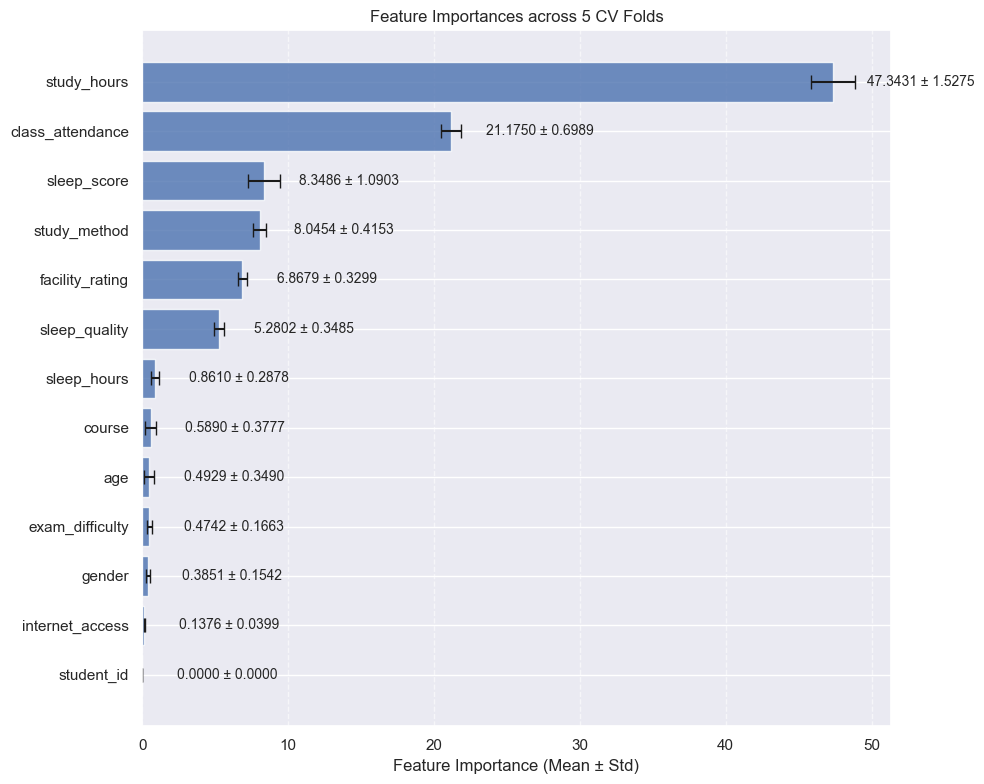

In [28]:
models_3 = k_fold_training(train_valid_copy,y_train_valid,cat_cols,params,n_folds,seed)

Average score and std for 5 folds on validation dataset: 7.9836 +- 0.0510


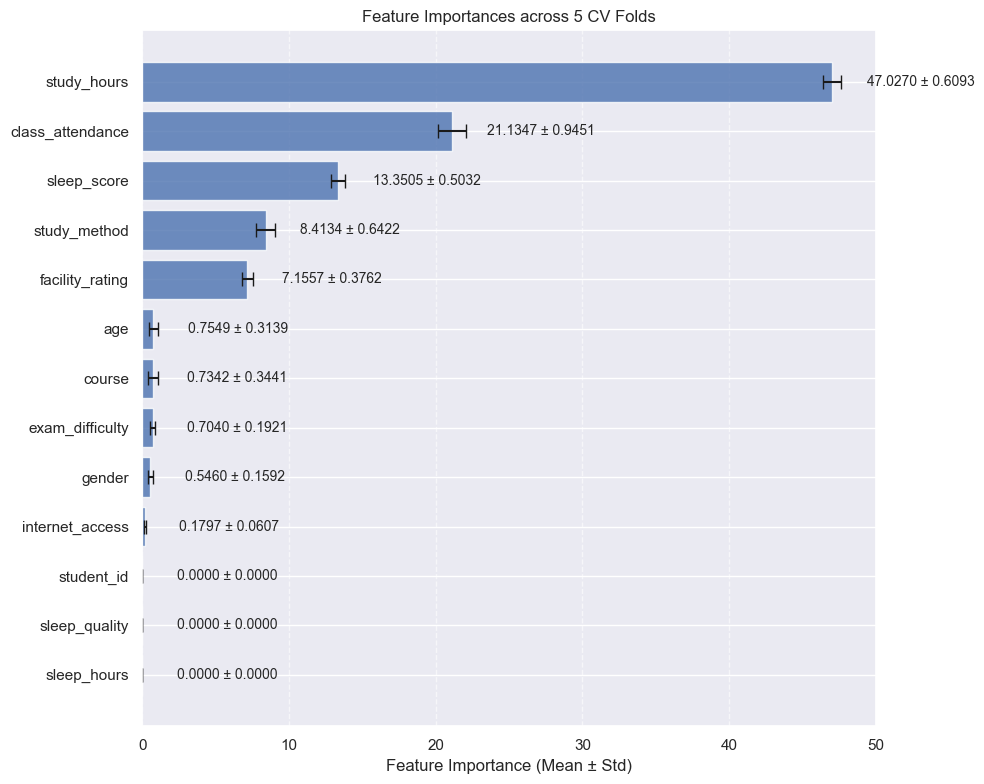

In [29]:
params['ignored_features'] = ['student_id','sleep_hours','sleep_quality']
models_4 = k_fold_training(train_valid_copy,y_train_valid,cat_cols,params,n_folds,seed)

In [46]:
## Object Importance - для больших шумных датасетов можно попробовать. В нашем случае он лишь увеличивает ошибку

# series_list = []

# for i, model in enumerate(models_1):
#     idxs, scores = model.get_object_importance(
#         test_pool, 
#         train_valid_pool,
#         importance_values_sign="All",
#         thread_count=-1
#     )
#     s = pd.Series(scores, index=idxs, name=f'model_{i}')
#     series_list.append(s)

# #
# df_imp = pd.concat(series_list, axis=1)


# df_imp['mean_imp'] = df_imp.mean(axis=1)
# index_of_noise = df_imp.mean_imp.sort_values(ascending=False).index.to_list()
# X_clean = X.copy().drop(index=index_of_noise[:50], errors='ignore')
# y_clean = y.copy().drop(index=index_of_noise[:50], errors='ignore')
# X_cl_train, X_cl_test, y_cl_train, y_cl_test = train_test_split(X_clean,y_clean,train_size=0.2,random_state=seed)
# params['ignored_features'] = ['student_id']
# models_5 = k_fold_training(X_cl_train,y_cl_train,cat_cols,params,n_folds,seed)

In [47]:
# index_of_noise = df_imp.mean_imp.sort_values(ascending=False).index.to_list()
# X_clean = X.copy().drop(index=index_of_noise[:50], errors='ignore')
# y_clean = y.copy().drop(index=index_of_noise[:50], errors='ignore')
# X_cl_train, X_cl_test, y_cl_train, y_cl_test = train_test_split(X_clean,y_clean,train_size=0.2,random_state=seed)
# params['ignored_features'] = ['student_id']
# models_5 = k_fold_training(X_cl_train,y_cl_train,cat_cols,params,n_folds,seed)


In [ ]:
import optuna
from optuna.samplers import TPESampler
from catboost.utils import eval_metric

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree','Depthwise', 'Lossguide']), small dataset, symmetricTree + 
        # Ordered boosting type sounds good 
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 1, 10),
        'max_ctr_complexity': trial.suggest_int('max_ctr_complexity',1,4),
        'cat_features': cat_cols,
        'train_dir': None,
        'ignored_features': ['student_id','internet_access'],
    }

    
    model = CatBoostRegressor(**params, random_seed=seed)
    model.fit(X_train,y_train, verbose=0, eval_set=(X_valid,y_valid))
    y_pred = model.predict(X_valid)
    return eval_metric(y_valid, y_pred, metric = metric)

sampler = TPESampler(seed=seed)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=20)

[I 2025-12-13 12:05:11,740] A new study created in memory with name: no-name-9021165e-7690-4a5e-83c7-36f0e95715b8
[I 2025-12-13 12:05:25,081] Trial 0 finished with value: 7.8481827669619735 and parameters: {'learning_rate': 0.08407993066388128, 'depth': 3, 'l2_leaf_reg': 2.8969357593816456, 'boosting_type': 'Ordered', 'one_hot_max_size': 7, 'max_ctr_complexity': 1}. Best is trial 0 with value: 7.8481827669619735.
[I 2025-12-13 12:05:37,532] Trial 1 finished with value: 7.913139536554309 and parameters: {'learning_rate': 0.09645886520238148, 'depth': 10, 'l2_leaf_reg': 5.690148852441014, 'boosting_type': 'Plain', 'one_hot_max_size': 8, 'max_ctr_complexity': 2}. Best is trial 0 with value: 7.8481827669619735.
[I 2025-12-13 12:05:43,868] Trial 2 finished with value: 7.84761406595372 and parameters: {'learning_rate': 0.07919247756913685, 'depth': 6, 'l2_leaf_reg': 9.334932143741483, 'boosting_type': 'Ordered', 'one_hot_max_size': 9, 'max_ctr_complexity': 2}. Best is trial 2 with value: 7.8

In [ ]:
final_params = {**params,**study.best_params,
                'iterations' : 3000, # there was no min value with default
                'ignored_features' : ['student_id','internet_access']
    }
final_params

NameError: name 'study' is not defined

In [15]:
cbr_final = CatBoostRegressor(**final_params)
# X_train_imp_ftr = X_train.drop(['student_id','internet_access'],axis=1).copy()
# X_valid_imp_ftr = X_valid.drop(['student_id','internet_access'],axis=1).copy()
cbr_final.fit(X_train,y_train, cat_features = cat_cols, eval_set=(X_valid,y_valid), plot = True)

y_pred = cbr_final.predict(X_test)

print('Test dataset:',eval_metric(y_test.values, y_pred, metric = metric))


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test dataset: [7.843265709635819]
